## Polynomial regression

On this page we will look at another extension of the linear model, called polynomial regression. Somewhat paradoxically, it lets us model more complex, curved and non-linear relationships. We'll see what this means specifically in a moment. What we will learn on this page applies to all generalized linear models, of which you will remember linear regression is a special case. With regard to other generalized linear models, the effect is the same - it lets us model more complex and non-linear relationships.

You'll remember that all generalized linear models have the following form:

$\Large f(\hat{\mu}_i) = b_0 + b_1 x_{1i} + b_2 x_{2i} + ... b_k x_{ki}$

Where, on the left hand side of the equals sign, we have $\hat{\mu}_i$ (our predicted outcome score), and $f()$ the *link* function. The link function, depending what it is, can force the predictions to fall on a specific scale, as we saw with logistic regression.

What we will learn today about polynomial regression applies to the righthand side of the equation above and as such it can be used with every type of generalized linear model (GLM). The models we will use today use the identity link function (e.g. the same one as linear regression), so they produce predictions potentially ranging from negative to positive infinity. (Typically these are the models we would refer to as "polynomial regression", but the modifications to the right hand side of the equation can be used with any GLM).

We will look at fitting polynomial regression models from both a "Culture One" and "Culture Two" perspective, and will continue exploring concepts relating to overfitting and underfitting, and balancing complexity and parsimony.

The dataset we will use from this page is from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/9/auto+mpg) and regards the fuel consumption of various models of cars. Here is a description of each of the variables in this dataset (from [here](https://www.kaggle.com/code/xshaimaa/auto-mpg-dataset-eda)):

`mpg` - miles per galon of fuel (continuous variable)

`cylinders` - number of engine cylinders (multi-valued discrete variable).

`displacement` - [volume of air displaced by the engine] (continuous variable)

`horsepower` - the power produced by engine to move the car (continuous variable)

`weight` - car weight (continuous variable)

`acceleration` - the acceleration an engine can get per second (continuous variable)

`year` - car release year from 1970 to 1982(multi-valued discrete variable)

`origin` - car manufacturing place (1 -> USA, 2 -> Europe, 3 -> Asia) (multi-valued discrete variable)

`name` - car model name (unique for each instance)

Let's begin by importing some libraries:

In [36]:
# library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
import statsmodels.formula.api as smf
from jupyprint import jupyprint, arraytex
from ipywidgets import interact

# interactive plotting function
def plotly_3D_polynomial(dataset, x1_string, x2_string, y_string, hover_string_list,
                         x1_slope, x2_slope, intercept, x1_poly_slopes, model_title_string=''):
    """Interactive 3D scatter, via plotly."""
    
    # create the scatterplot
    scatter_3d = px.scatter_3d(dataset, x=x1_string, y=x2_string, z=y_string,
                          hover_data= hover_string_list)

    # generate the regression surface
    x1 = np.linspace(np.min(dataset[x1_string]), np.max(dataset[x1_string]))
    x2 = np.linspace(np.min(dataset[x2_string]), np.max(dataset[x2_string]))
    x1, x2 = np.meshgrid(x1, x2)

    # generate predictions without the polynomial term
    y = x1_slope * x1 + x2_slope * x2 + intercept

    # add in the polynomial term
    for slope, degree in zip(x1_poly_slopes, np.arange(2, len(x1_poly_slopes)+2)):
        y = y + slope * x1**degree
    
    scatter_3d.add_trace(go.Surface(x=x1, y=x2, z=y, opacity=0.6))
                     
    # add a title to the plot and adjust view angle
    scatter_3d.update_layout(title=model_title_string,
                             scene={'camera': {'up': {'x': 0, 'y': 0, 'z': 1},
                                    'center': {'x': 0, 'y': 0, 'z': 0},
                                    'eye': {'x': 1.6, 'y': -1.6, 'z': 0.6}}},
                                     legend={"yanchor" : "top",
                                        "y" : 0.99,
                                        "xanchor" : "left",
                                        "x" : 0.01})
    # show the plot
    scatter_3d.show()

# import the data
cars_df = pd.read_csv('data/Auto.csv')

display(cars_df.head(20))

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
5,15.0,8,429.0,198,4341,10.0,70,1,ford galaxie 500
6,14.0,8,454.0,220,4354,9.0,70,1,chevrolet impala
7,14.0,8,440.0,215,4312,8.5,70,1,plymouth fury iii
8,14.0,8,455.0,225,4425,10.0,70,1,pontiac catalina
9,15.0,8,390.0,190,3850,8.5,70,1,amc ambassador dpl


The first model we will fit is specified below:

`mpg ~ horsepower`

...meaning we will predict `mpg` as a function of `horsepower`.

As always, it's a good idea to start with graphically inspecting the data, so lets inspect a scatterplot of these two variables:

In [37]:
# create a bivariate scatterplot of `mpg ~ horsepower`
fig = px.scatter(x='horsepower', y='mpg', data_frame=cars_df, hover_data='name')
fig.update_traces(marker={'color':'blue'})
fig.update_layout(width=500, height=500)
fig.show()

From graphically inspecting the data we can see a clear curve in the relationship between the two variables. As we move along the `horsepower` axis the values of `mpg` generally get lower, but the rate at which they get lower is much steeper at lower values of `horsepower`. These are the sorts of relationships that polynomial regression lets us model.

#### A Thought Experiment (of sorts)

For the purposes of this page it will be conceptually useful to engage in a [thought experiment](https://plato.stanford.edu/Entries/thought-experiment/). Such thought experiments are more commonly used in philosophy than in data science, but they will be useful for thinking about certain aspects of model-fitting.

In reality, the car models in this dataset are a subset of all the car models that existed in the 1970s/1980s. But I would like you to imagine that we are on a small island, and that this dataset is exhaustive of all the cars that exist on the island. For some of the variables, we may have to do a bit of additional imagining here - for instance, we will treat `origin` as reflecting which part of the island the model comes from etc.

The key aspect here isto imagine that the points on the scatterplot above represent the complete population of the car models available on the island. We are going to restrict our analysis to a small random sample of these cars, to simulate the typical situation that a data analyst is in, but with the added benefit of being able to 'peek' at the population as a whole whenever we want.

The code cell below takes a random sample of 30 cars from (what we are pretending is) the full population:

In [38]:
# simulate the normal situation we are in, in data science,
# by taking a random sample from the population data
sample = cars_df.sample(30, random_state=30)

# show the sample
sample

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
359,26.6,8,350.0,105,3725,19.0,81,1,oldsmobile cutlass ls
368,24.0,4,140.0,92,2865,16.4,82,1,ford fairmont futura
126,15.0,6,250.0,100,3336,17.0,74,1,chevrolet nova
150,19.0,6,225.0,95,3264,16.0,75,1,plymouth valiant custom
217,25.5,4,122.0,96,2300,15.5,77,1,plymouth arrow gs
259,18.1,6,258.0,120,3410,15.1,78,1,amc concord d/l
228,15.5,8,350.0,170,4165,11.4,77,1,chevrolet monte carlo landau
129,32.0,4,71.0,65,1836,21.0,74,3,toyota corolla 1200
38,14.0,8,400.0,175,4464,11.5,71,1,pontiac catalina brougham
294,27.4,4,121.0,80,2670,15.0,79,1,amc spirit dl


Lets play `mpg` as a function of `horsepower`, but using just our sample data:

In [39]:
# plot the data from the sample
fig = px.scatter(x='horsepower', y='mpg', data_frame=sample, hover_data='name')
fig.update_traces(marker={'color':'red'})
fig.update_layout(width=500, height=500)
fig.show()

To give you an intuition as to why we might want to use a polynomial regression model, lets fit the now (very familiar) linear regression model to our sample data. E.g. this will let us see why we would benefit from being able to model the curvature.

As you know the equation for the linear regression model is:

$ \Large y_i = b_0 + b_1 \times x_1 + \varepsilon_i $

When we drop the error vector ($\varepsilon_i $) we get the equation for the "systematic part" of the model (e.g. the predictions/fitted values):

$ \Large \hat{y}_i = b_0 + b_1 \times x_1 $

You'll remember that where there are $k$ predictors, and $n$ observations, the error vector is computed as follows:

$$
\vec{\varepsilon}= \begin{bmatrix}
           y_1 - \hat{y}_1 \\
           y_2 - \hat{y}_2 \\
           \vdots \\
           y_n - \hat{y}_n
         \end{bmatrix}              
$$


We'll use the root mean squared error cost function - this returns the same parameter estimates as the sum of squares cost function, but gives us a sense of the average prediction error from the model, on the scale of the original target/outcome variable. The root mean squared error (RMSE) is the square root of the average of squared errors, and can be written as: 

$\Large \text{RMSE} = \sqrt{\frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{n}}$

Or, equivalently (you may sometimes see it written as:

$\Large \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$

The cell below defines this cost function (and you'll see from the last line it is much simpler in python than it looks to be from the formula...):

In [40]:
# define the root mean square error cost function for linear regression
def rmse(intercept_and_slope, x1, y):
    
    # unpack the slope and intercept
    intercept, slope = intercept_and_slope
    
    # generate predictions
    y_hat = intercept + slope * x1
    
    # calculate the errors
    errors = y - y_hat
    
    # return the root mean squared error
    return np.sqrt(np.mean(errors**2))

In [41]:
# test the cost function
rmse([1, 1], sample['horsepower'], sample['mpg'])

93.93023829772108

Using the familiar routine, we'll get our linear regression slope and intercept by passing our `rmse` cost function to `minimize`:

In [42]:
from scipy.optimize import minimize

# get the linear regression parameter estimates, via `minimize`
lin_reg_1 = minimize(rmse,
                     [1, 1],
                     args=(sample['horsepower'],
                     sample['mpg']))

# show the output from `minimize`
lin_reg_1

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 4.744350009017296
        x: [ 3.682e+01 -1.341e-01]
      nit: 17
      jac: [ 0.000e+00  1.788e-07]
 hess_inv: [[ 4.011e+01 -3.377e-01]
            [-3.377e-01  3.224e-03]]
     nfev: 57
     njev: 19

Let's pull out the slope and intercept and store them as separate variables:

In [43]:
# get our parameter estimates
intercept_lin_reg_1 = lin_reg_1.x[0]
slope_lin_reg_1 = lin_reg_1.x[1]

# show the parameter estimates
jupyprint(f"From linear regression, the intercept is <b> {intercept_lin_reg_1.round(3)} </b> and the slope is <b>{slope_lin_reg_1.round(3)} </b>.")

From linear regression, the intercept is <b> 36.818 </b> and the slope is <b>-0.134 </b>.

Let's check these parameter estimates against `statsmodels`:

In [44]:
# fit a linear regression, `mpg ~ horsepower` using statsmodels
lin_reg_1_sm = smf.ols('mpg ~ horsepower', data=sample).fit()
lin_reg_1_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     33.36
Date:                Fri, 23 Feb 2024   Prob (F-statistic):           3.35e-06
Time:                        09:20:59   Log-Likelihood:                -89.277
No. Observations:                  30   AIC:                             182.6
Df Residuals:                      28   BIC:                             185.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.8183      2.592     14.204      0.000      31.509      42.128
horsepower    -0.1341      0.023     -5.776      0.000      -0.182      -0.087
==============================================================================
Omnibus:                        1.550   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.461   Jarque-Bera (JB):                0.949
Skew:                           0.435   Prob(JB):                        0.622
Kurtosis:                       3.033   Cond. No.                         323.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The plot below shows the best-fitting linear regression model, along with the errors:

In [45]:
# generate predictions from the parameter estimates
predictions_lin_reg_1 = intercept_lin_reg_1 + slope_lin_reg_1*sample['horsepower']

# calculate the errors (AKA the residuals)
errors = sample['mpg'] - predictions_lin_reg_1

# create the plot
fig = px.scatter(x='horsepower', y='mpg', data_frame=sample, hover_data='name')
xs_for_plot = np.linspace(sample['horsepower'].min(), sample['horsepower'].max())
fig.add_trace(go.Scatter(x=xs_for_plot, y=intercept_lin_reg_1 + slope_lin_reg_1*xs_for_plot, name='Linear Regression'))
fig.add_trace(go.Scatter(x=[None], y =[None], name='Errors',   line={'dash':'dash', 'color': 'lightblue'}))
for i in np.arange(len(sample)):
    fig.add_shape(go.layout.Shape(x1=sample.iloc[i]['horsepower'],
                                  x0=sample.iloc[i]['horsepower'],
                                  y0=sample.iloc[i]['mpg'],
                                  y1=intercept_lin_reg_1 + slope_lin_reg_1 * sample.iloc[i]['horsepower'],
                                  name='Errors' if i == 0 else "",
                                  line={'dash':'dash', 'color': 'lightblue'}
                                  ))
fig.update_layout(width=700, height=500,
                  title=f'RMSE = {round(rmse([intercept_lin_reg_1, slope_lin_reg_1],sample["horsepower"], sample["mpg"]),2)}')
fig.show()

This model looks OK - as it goes, it is capturing the general trend of the association, but you'll notice that the errors are much larger at lower values of horsepower.

This means there is *systematicity* (a nonrandom pattern) in the errors. For a well-fitting linear regression - in fact, for any well-fitting model - we would like the errors to be randomly distributed around the regression line.

*Systematicity in the errors suggests that there is information in the data which is not being used by the model.* This suggests that a more complex model might be needed, to make use of this additional information.

We can elicit this same information using a "fitted vs residuals" plot. This is where we create a scatterplot of the fitted values ($\hat{y}$) from the model against the error values ($e_i$) from the model. This plot can help us check for systematicity in the errors.

The code cell below creates such a plot:

In [46]:
# inspect the fitted vs residuals plot
fig = px.scatter(x=predictions_lin_reg_1, y=errors)
fig.update_layout(width=500, height=500, xaxis_title='Predictions',
    yaxis_title='Errors', title="Fitted vs Residuals Plot")
fig.update_traces(marker=dict(symbol='x', size=8, color='red'))
fig.show()

Ideally, if the linear regression fits optimally we want the pattern on this plot to be completely random.

The code cell below generates a scatterplot showing two randomly associated variables, for comparison.

Re-run the cell below a few times and compare it to the "fitted vs residuals" plot: **do you think the fitted vs residuals plot looks random?**

In [47]:
# generate a randomly associated bivariate scatterplot, for comparison
fig = px.scatter(x=np.random.normal(100, 10, 30), y=np.random.normal(100, 10, 30))
fig.update_layout(width=500, height=500)
fig.update_traces(marker=dict(symbol='x', size=8, color='red'))

Let's make the trend in the fitted vs residuals plot a bit easier to see.
We can do this using the `trendline='lowess'` argument in the `px.scatter()` function.

This adds a trendline via flexible, nonparametric method, and can be very useful for quickly inspecting relationships:

In [48]:
# add a trendline to show the need for a nonlinear term in the model
fig = px.scatter(x=predictions_lin_reg_1, y=errors, trendline='lowess')
fig.update_layout(width=500, height=500, xaxis_title='Predictions',
    yaxis_title='Errors', title="Fitted vs Residuals Plot (with trendline)")
fig.update_traces(marker=dict(symbol='x', size=8, color='red'))
fig.show()

We can clearly see a "curved" trend in the fitted vs residuals plot. This suggests that there is sytematicity in the residuals, and the need for a more complex model.

## Polynomial regression notation

So, for our fitted vs residual plot, we can see that there is some systematic relationship between `horsepower` and `mpg` which is not currently being utilised by the model.

Polynomial regression can help us out here. Let's have a look at how it works/how it differs from linear regression, at the level of its notation (it is simpler than it may look at first):

You'll remember the vector notation for linear regression (shown here for a dataset with 15 observational units):

$ \vec{y} = b_1 \vec{x_1} + \text{c} + \vec{\varepsilon} $

$\begin{bmatrix}{} \text{$y_{1}$} \\ \text{$y_{2}$} \\ \text{$y_{3}$} \\ \text{$y_{4}$} \\ \text{$y_{5}$} \\ \text{$y_{6}$} \\ \text{$y_{7}$} \\ \text{$y_{8}$} \\ \text{$y_{9}$} \\ \text{$y_{10}$} \\ \text{$y_{11}$} \\ \text{$y_{12}$} \\ \text{$y_{13}$} \\ \text{$y_{14}$} \\ \text{$y_{15}$} \\ \end{bmatrix} = b * \begin{bmatrix}{} \text{$x_{1}$} \\ \text{$x_{2}$} \\ \text{$x_{3}$} \\ \text{$x_{4}$} \\ \text{$x_{5}$} \\ \text{$x_{6}$} \\ \text{$x_{7}$} \\ \text{$x_{8}$} \\ \text{$x_{9}$} \\ \text{$x_{10}$} \\ \text{$x_{11}$} \\ \text{$x_{12}$} \\ \text{$x_{13}$} \\ \text{$x_{14}$} \\ \text{$x_{15}$} \\ \end{bmatrix} + c + \begin{bmatrix}{} \text{$\varepsilon_{1}$} \\ \text{$\varepsilon_{2}$} \\ \text{$\varepsilon_{3}$} \\ \text{$\varepsilon_{4}$} \\ \text{$\varepsilon_{5}$} \\ \text{$\varepsilon_{6}$} \\ \text{$\varepsilon_{7}$} \\ \text{$\varepsilon_{8}$} \\ \text{$\varepsilon_{9}$} \\ \text{$\varepsilon_{10}$} \\ \text{$\varepsilon_{11}$} \\ \text{$\varepsilon_{12}$} \\ \text{$\varepsilon_{13}$} \\ \text{$\varepsilon_{14}$} \\ \text{$\varepsilon_{15}$} \\ \end{bmatrix}$


You'll also remember that our $y$ and $x$ vectors are fixed, we try different values of $b$ and $c$ and these give us specific error vectors. The best fitting parameters ($b$ and $c$) are the ones which give us the "smallest" error vector (measured in this case by the RMSE calculated from the error vector).

Polynomial regression works on identifical principles only the polynomial regression model has extra $x$ vectors, containing the same values but raised to a power (the power is also referred to as the *degree* ($d$)). In the regression model equation, the predictor which is raised to the power $d$ is called the/a *polynomial term*.

The vector notation for the polynomial regression model is below (we'll keep it simple for now, with only one polynomial term):

$ \vec{y} = b_1 \vec{x_1} + b_2 \vec{x^{d}_{1}} + \text{c} + \vec{\varepsilon} $

So, we are taking the values in the predictor vector and raising them all to the power $d$:

$\begin{bmatrix}{} \text{$y_{1}$} \\ \text{$y_{2}$} \\ \text{$y_{3}$} \\ \text{$y_{4}$} \\ \text{$y_{5}$} \\ \text{$y_{6}$} \\ \text{$y_{7}$} \\ \text{$y_{8}$} \\ \text{$y_{9}$} \\ \text{$y_{10}$} \\ \text{$y_{11}$} \\ \text{$y_{12}$} \\ \text{$y_{13}$} \\ \text{$y_{14}$} \\ \text{$y_{15}$} \\ \end{bmatrix} = b * \begin{bmatrix}{} \text{$x_{1}$} \\ \text{$x_{2}$} \\ \text{$x_{3}$} \\ \text{$x_{4}$} \\ \text{$x_{5}$} \\ \text{$x_{6}$} \\ \text{$x_{7}$} \\ \text{$x_{8}$} \\ \text{$x_{9}$} \\ \text{$x_{10}$} \\ \text{$x_{11}$} \\ \text{$x_{12}$} \\ \text{$x_{13}$} \\ \text{$x_{14}$} \\ \text{$x_{15}$} \\ \end{bmatrix} + \begin{bmatrix} x_{1}^d \\ x_{2}^d \\ x_{3}^d \\ x_{4}^d \\ x_{5}^d \\ x_{6}^d \\ x_{7}^d \\ x_{8}^d \\ x_{9}^d \\ x_{10}^d \\ x_{11}^d \\ x_{12}^d \\ x_{13}^d \\ x_{14}^d \\ x_{15}^d \\
\end{bmatrix}+ c + \begin{bmatrix}{} \text{$\varepsilon_{1}$} \\ \text{$\varepsilon_{2}$} \\ \text{$\varepsilon_{3}$} \\ \text{$\varepsilon_{4}$} \\ \text{$\varepsilon_{5}$} \\ \text{$\varepsilon_{6}$} \\ \text{$\varepsilon_{7}$} \\ \text{$\varepsilon_{8}$} \\ \text{$\varepsilon_{9}$} \\ \text{$\varepsilon_{10}$} \\ \text{$\varepsilon_{11}$} \\ \text{$\varepsilon_{12}$} \\ \text{$\varepsilon_{13}$} \\ \text{$\varepsilon_{14}$} \\ \text{$\varepsilon_{15}$} \\ \end{bmatrix}$

So, if $d == 2$, then:

$ \vec{y} = b_1 \vec{x_1} + b_2 \vec{x^{2}_{1}} + \text{c} + \vec{\varepsilon} $

$\begin{bmatrix}{} \text{$y_{1}$} \\ \text{$y_{2}$} \\ \text{$y_{3}$} \\ \text{$y_{4}$} \\ \text{$y_{5}$} \\ \text{$y_{6}$} \\ \text{$y_{7}$} \\ \text{$y_{8}$} \\ \text{$y_{9}$} \\ \text{$y_{10}$} \\ \text{$y_{11}$} \\ \text{$y_{12}$} \\ \text{$y_{13}$} \\ \text{$y_{14}$} \\ \text{$y_{15}$} \\ \end{bmatrix} = b_1 * \begin{bmatrix}{} \text{$x_{1}$} \\ \text{$x_{2}$} \\ \text{$x_{3}$} \\ \text{$x_{4}$} \\ \text{$x_{5}$} \\ \text{$x_{6}$} \\ \text{$x_{7}$} \\ \text{$x_{8}$} \\ \text{$x_{9}$} \\ \text{$x_{10}$} \\ \text{$x_{11}$} \\ \text{$x_{12}$} \\ \text{$x_{13}$} \\ \text{$x_{14}$} \\ \text{$x_{15}$} \\ \end{bmatrix} + b_2 \begin{bmatrix} x_{1}^2 \\ x_{2}^2 \\ x_{3}^2 \\ x_{4}^2 \\ x_{5}^2 \\ x_{6}^2 \\ x_{7}^2 \\ x_{8}^2 \\ x_{9}^2 \\ x_{10}^2 \\ x_{11}^2 \\ x_{12}^2 \\ x_{13}^2 \\ x_{14}^2 \\ x_{15}^2 \\
\end{bmatrix}+ c + \begin{bmatrix}{} \text{$\varepsilon_{1}$} \\ \text{$\varepsilon_{2}$} \\ \text{$\varepsilon_{3}$} \\ \text{$\varepsilon_{4}$} \\ \text{$\varepsilon_{5}$} \\ \text{$\varepsilon_{6}$} \\ \text{$\varepsilon_{7}$} \\ \text{$\varepsilon_{8}$} \\ \text{$\varepsilon_{9}$} \\ \text{$\varepsilon_{10}$} \\ \text{$\varepsilon_{11}$} \\ \text{$\varepsilon_{12}$} \\ \text{$\varepsilon_{13}$} \\ \text{$\varepsilon_{14}$} \\ \text{$\varepsilon_{15}$} \\ \end{bmatrix}$

This case, where $d == 2$, is called *quadratic regression*. We're now estimating two slopes *for the same predictor variable $x1$*.

As with many things in data science, this looks simpler in code than in mathematical notation!

Here is our original predictor vector:

In [49]:
# here are the scores on the predictor variable
sample['horsepower'].values

array([105,  92, 100,  95,  96, 120, 170,  65, 175,  80, 130,  88,  88,
        81, 190, 150,  69,  90,  85,  70,  90,  88,  74,  72, 210,  93,
        85, 150,  65,  76], dtype=int64)

And here it is raised to the power of 2 (e.g. where $d$ == 2):

In [50]:
# here are the scores on the predictor variable, raised to the second degree (e.g. d == 2)
sample['horsepower'].values**2

array([11025,  8464, 10000,  9025,  9216, 14400, 28900,  4225, 30625,
        6400, 16900,  7744,  7744,  6561, 36100, 22500,  4761,  8100,
        7225,  4900,  8100,  7744,  5476,  5184, 44100,  8649,  7225,
       22500,  4225,  5776], dtype=int64)

So, the vector notation for the quadratic regression model, using our actual data*, is shown below:

*Showing the first 15 observational units, to keep it easy to view...

In [51]:
y_string = "\\begin{bmatrix}{} \\text{$y_{1}$} \\\\ \\text{$y_{2}$} \\\\ \\text{$y_{3}$} \\\\ \\text{$y_{4}$} \\\\ \\text{$y_{5}$} \\\\ \\text{$y_{6}$} \\\\ \\text{$y_{7}$} \\\\ \\text{$y_{8}$} \\\\ \\text{$y_{9}$} \\\\ \\text{$y_{10}$} \\\\ \\text{$y_{11}$} \\\\ \\text{$y_{12}$} \\\\ \\text{$y_{13}$} \\\\ \\text{$y_{14}$} \\\\ \\text{$y_{15}$} \\\\ \\end{bmatrix}"
error_string =  "\\begin{bmatrix}{} \\text{$\\varepsilon_{1}$} \\\\ \\text{$\\varepsilon_{2}$} \\\\ \\text{$\\varepsilon_{3}$} \\\\ \\text{$\\varepsilon_{4}$} \\\\ \\text{$\\varepsilon_{5}$} \\\\ \\text{$\\varepsilon_{6}$} \\\\ \\text{$\\varepsilon_{7}$} \\\\ \\text{$\\varepsilon_{8}$} \\\\ \\text{$\\varepsilon_{9}$} \\\\ \\text{$\\varepsilon_{10}$} \\\\ \\text{$\\varepsilon_{11}$} \\\\ \\text{$\\varepsilon_{12}$} \\\\ \\text{$\\varepsilon_{13}$} \\\\ \\text{$\\varepsilon_{14}$} \\\\ \\text{$\\varepsilon_{15}$} \\\\ \\end{bmatrix}"
jupyprint(f"${y_string} = b_1 {arraytex(np.atleast_2d(sample['horsepower'].values[:15]).T)} + b_2{arraytex(np.atleast_2d(sample['horsepower'].values[:15]**2).T)} + {error_string}$")

$\begin{bmatrix}{} \text{$y_{1}$} \\ \text{$y_{2}$} \\ \text{$y_{3}$} \\ \text{$y_{4}$} \\ \text{$y_{5}$} \\ \text{$y_{6}$} \\ \text{$y_{7}$} \\ \text{$y_{8}$} \\ \text{$y_{9}$} \\ \text{$y_{10}$} \\ \text{$y_{11}$} \\ \text{$y_{12}$} \\ \text{$y_{13}$} \\ \text{$y_{14}$} \\ \text{$y_{15}$} \\ \end{bmatrix} = b_1 \begin{bmatrix}{} 105 \\ 92 \\ 100 \\ 95 \\ 96 \\ 120 \\ 170 \\ 65 \\ 175 \\ 80 \\ 130 \\ 88 \\ 88 \\ 81 \\ 190 \\ \end{bmatrix} + b_2\begin{bmatrix}{} 11025 \\ 8464 \\ 10000 \\ 9025 \\ 9216 \\ 14400 \\ 28900 \\ 4225 \\ 30625 \\ 6400 \\ 16900 \\ 7744 \\ 7744 \\ 6561 \\ 36100 \\ \end{bmatrix} + \begin{bmatrix}{} \text{$\varepsilon_{1}$} \\ \text{$\varepsilon_{2}$} \\ \text{$\varepsilon_{3}$} \\ \text{$\varepsilon_{4}$} \\ \text{$\varepsilon_{5}$} \\ \text{$\varepsilon_{6}$} \\ \text{$\varepsilon_{7}$} \\ \text{$\varepsilon_{8}$} \\ \text{$\varepsilon_{9}$} \\ \text{$\varepsilon_{10}$} \\ \text{$\varepsilon_{11}$} \\ \text{$\varepsilon_{12}$} \\ \text{$\varepsilon_{13}$} \\ \text{$\varepsilon_{14}$} \\ \text{$\varepsilon_{15}$} \\ \end{bmatrix}$

If we add higher order polynomial terms (e.g. raised to the power of 3, 4, 5, 6 ... 16 and so on) then we add a new $x$ vector for each polynomial term.

$\begin{bmatrix}{} \text{$y_{1}$} \\ \text{$y_{2}$} \\ \text{$y_{3}$} \\ \text{$y_{4}$} \\ \text{$y_{5}$} \\ \text{$y_{6}$} \\ \text{$y_{7}$} \\ \text{$y_{8}$} \\ \text{$y_{9}$} \\ \text{$y_{10}$} \\ \text{$y_{11}$} \\ \text{$y_{12}$} \\ \text{$y_{13}$} \\ \text{$y_{14}$} \\ \text{$y_{15}$} \\ \end{bmatrix} = b_1 * \begin{bmatrix}{} \text{$x_{1}$} \\ \text{$x_{2}$} \\ \text{$x_{3}$} \\ \text{$x_{4}$} \\ \text{$x_{5}$} \\ \text{$x_{6}$} \\ \text{$x_{7}$} \\ \text{$x_{8}$} \\ \text{$x_{9}$} \\ \text{$x_{10}$} \\ \text{$x_{11}$} \\ \text{$x_{12}$} \\ \text{$x_{13}$} \\ \text{$x_{14}$} \\ \text{$x_{15}$} \\ \end{bmatrix} + b_2 \begin{bmatrix} x_{1}^2 \\ x_{2}^2 \\ x_{3}^2 \\ x_{4}^2 \\ x_{5}^2 \\ x_{6}^2 \\ x_{7}^2 \\ x_{8}^2 \\ x_{9}^2 \\ x_{10}^2 \\ x_{11}^2 \\ x_{12}^2 \\ x_{13}^2 \\ x_{14}^2 \\ x_{15}^2 \\
\end{bmatrix}+ ... + b_k \begin{bmatrix} x_{1}^d \\ x_{2}^d \\ x_{3}^d\\ x_{4}^d \\ x_{5}^d \\ x_{6}^d \\ x_{7}^d \\ x_{8}^d \\ x_{9}^d\\ x_{10}^d\\ x_{11}^d \\ x_{12}^d \\ x_{13}^d \\ x_{14}^d \\ x_{15}^d \\
\end{bmatrix}+c + \begin{bmatrix}{} \text{$\varepsilon_{1}$} \\ \text{$\varepsilon_{2}$} \\ \text{$\varepsilon_{3}$} \\ \text{$\varepsilon_{4}$} \\ \text{$\varepsilon_{5}$} \\ \text{$\varepsilon_{6}$} \\ \text{$\varepsilon_{7}$} \\ \text{$\varepsilon_{8}$} \\ \text{$\varepsilon_{9}$} \\ \text{$\varepsilon_{10}$} \\ \text{$\varepsilon_{11}$} \\ \text{$\varepsilon_{12}$} \\ \text{$\varepsilon_{13}$} \\ \text{$\varepsilon_{14}$} \\ \text{$\varepsilon_{15}$} \\ \end{bmatrix}$

What is the effect of using different values of $d$?

The graphs below show some of the common polynomial forms:

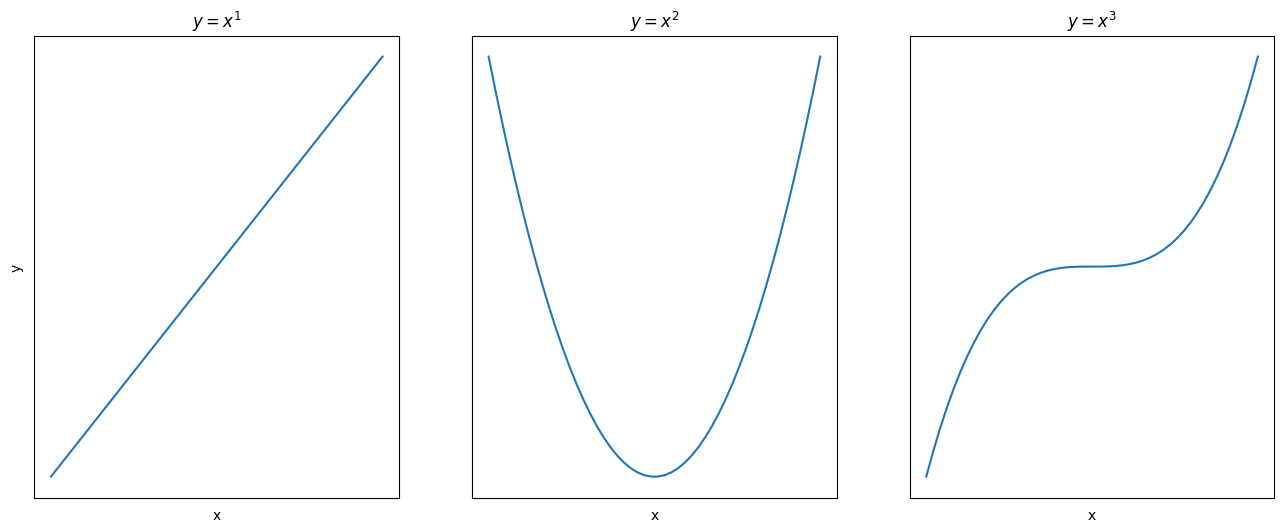

In [52]:
# generate the subplots below
x = np.linspace(-100, 100)
n_plots=3
plt.figure(figsize=(16,6))
def plot_polynomial_form(degree=1):
    x = np.linspace(-10000, 10000)
    plt.plot(x, x**degree)
    plt.xlabel('x')
for i in np.arange(1, n_plots+1):
    plt.subplot(1, n_plots, i)
    plot_polynomial_form(degree=i)
    plt.yticks([])
    plt.xticks([])
    if i == 1:
        plt.ylabel('y')
    plt.title('$y = x^{'+f'{i}'+'}$')

A polynomial regression where $d == 1$ is just linear regression!

We can see that when we include a higher degree polynomial, we introduce bends/curvature into the graph.

The code cell below generates some fake data with a specific "polynomial pattern" underlying it e.g. data for which a specific value of $d$ fits the simulated data well. (The true "data-generating" equation is shown above the graph):

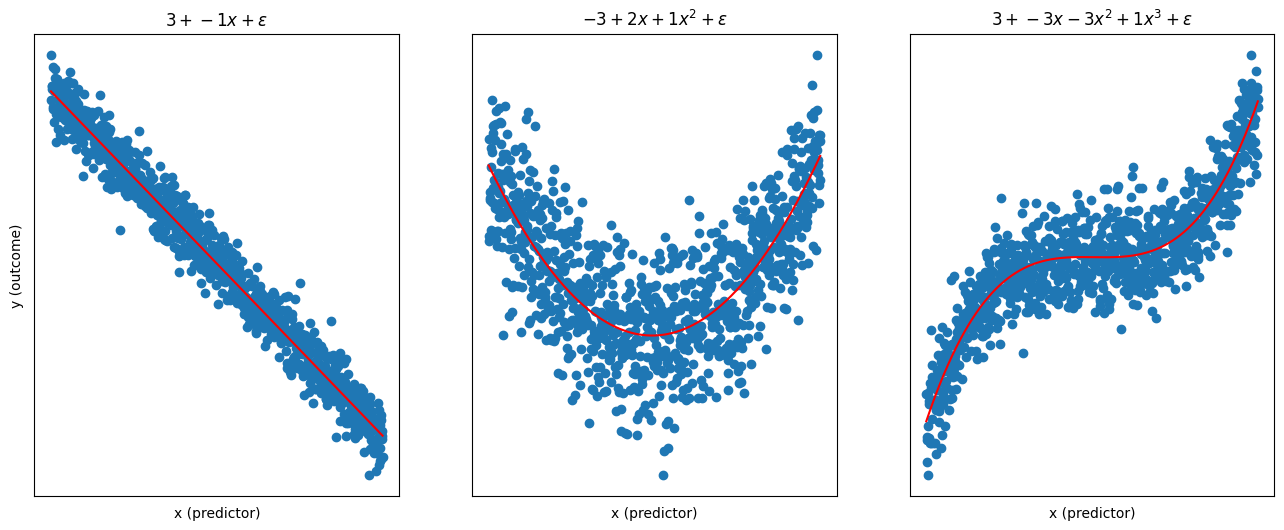

In [53]:
# generate the plots
x = np.linspace(-100, 100)
plt.figure(figsize=(16,6))
def plot_polynomial(degree=1):
    x = np.linspace(-100, 100, num=1000)
    intercept = np.random.choice([-3, -2, -1, 1, 2, 3])
    slopes = np.array([np.random.choice([-3, -2, -1, 1, 2, 3])])
    y = intercept + slopes[0]*x + np.random.normal(0, 10, 1000)
    full_equation_string = f"{intercept} + {slopes[0]}x"
    for i in np.arange(0, degree):
        if (i != 0):
            current_slope = np.random.choice([-3, -2, -1, 1, 2, 3])
            slopes = np.append(slopes, current_slope)
            y = y + slopes[i]*x**(i+1) + np.random.normal(0, 50**degree, 1000)
            if slopes[i] < 0:
                full_equation_string =  full_equation_string + f" {slopes[i]} x^{i+1}"
            elif slopes[i] >=0:
                full_equation_string =  full_equation_string + f" + {slopes[i]} x^{i+1}"
    plt.scatter(x, y)
    y_poly = np.poly1d(np.polyfit(x, y, degree))
    plt.plot(x, y_poly(x), color = 'red')
    plt.xlabel('x (predictor)')
    plt.title(f'${full_equation_string} + \\varepsilon$')

for i in np.arange(1, n_plots+1):
    plt.subplot(1, n_plots, i)
    full_eq_string = plot_polynomial(degree=i)
    plt.yticks([])
    plt.xticks([])
    if i == 1:
        plt.ylabel('y (outcome)')

The code cell below allows you to interact with the graphs above, change the degree of the polynomial term, and generate new simulated data.


Pay attention to the sign (+/-) of the different polynomial terms, it affects the "direction" of the curve:

In [54]:
# interactive plot
interact(plot_polynomial, degree=(1, 3, 1));

interactive(children=(IntSlider(value=1, description='degree', max=3, min=1), Output()), _dom_classes=('widget…

The higher the value of $d$, the more bends in the curve.

In fact each polynomial can have `degree - 1` bends, so second degree polynomial can have 1 bend, third degree can have 2 bends, a fourth degree polynomial can have three bends and so on.

*Note*: **polynomial terms are used with numeric predictors only** (e.g. they don't make sense to use with categorical, dummy-coded predictors).

The interactive graph below fits some different polynomial regression models to our sample data (we'll look at the mechanics of the fitting process shortly). You can use the slider to change the degree ($d$) of the polynomial and see how this affects the curve:

In [55]:
def how_many_degrees(max_degree=3, show_other_curves=False, show_pop=False):

    # isolate the "population" data not in the sample, for optional plotting later
    pop_plot_df = cars_df.loc[~pd.Series(cars_df.index).isin(sample.index)]
    
    # create the initial scatterplot, of the sample data
    fig = go.Figure()
    fig.add_scatter(x=sample['horsepower'],
                    y=sample['mpg'],
                    mode='markers',
                    name='sample data',
                    marker={'color':'red'})
    fig.update_layout(xaxis_title="horsepower",
                      yaxis_title="mpg")

    # if showing the "population" data, plot this also
    if show_pop == True:
        fig.add_scatter(x=pop_plot_df['horsepower'],
                        y=pop_plot_df['mpg'],
                        mode='markers',
                        name='population data',
                        marker={'color':'blue', 'opacity': 0.15})

    # ensure consistent trendline colours regardless of which options are used
    elif show_pop == False:
        fig.add_scatter(x=[],
                        y=[])

    # if showing other curves, or plotting only linear fit, show the linear fit
    if (show_other_curves==True) | (max_degree==1):
        # calculate the RMSE
        rmse_val = rmse([intercept_lin_reg_1, slope_lin_reg_1], sample['horsepower'], sample['mpg'])
        # add the linear trace
        fig.add_trace(go.Scatter(x=xs_for_plot, y=intercept_lin_reg_1 + slope_lin_reg_1*xs_for_plot,
                             name=f'Linear Regression; RMSE = {rmse_val.round(4)}',
                                line={'width': 5}))
        
    # ensure consistent curve colours regardless of option choise
    elif show_other_curves == False:
        fig.add_trace(go.Scatter(x=[], y=[]))
        
    # get coefficients for higher degree plots (from 2 to max degree)
    for i, degree in enumerate(np.arange(2, max_degree+1)):
        coefs = np.polyfit(sample['horsepower'], sample['mpg'], degree)
        errors = sample['mpg'] - np.polyval(coefs, sample['horsepower'])
        rmse_val = np.sqrt(np.mean(errors**2))

        # if showing other curves, add current curve
        if (show_other_curves == True) :
            fig.add_trace(go.Scatter(x=xs_for_plot,
                                 y=np.polyval(coefs, xs_for_plot),
                                 name=f'Degree = {degree}; RMSE = {rmse_val.round(4)}',
                                    line={'width': 5}))

        # if not showing other curves, skip all except the relevant curve
        elif (show_other_curves == False):
            if (degree != max_degree) :
                fig.add_trace(go.Scatter(x=[],
                                         y=[]))
            elif(degree == max_degree):
                fig.add_trace(go.Scatter(x=xs_for_plot,
                                 y=np.polyval(coefs, xs_for_plot),
                                 name=f'Degree = {max_degree}; RMSE = {rmse_val.round(4)}',
                                        line={'width': 5}))
    fig.update_layout(width=700, height=600)
    fig.show()
    
interact(how_many_degrees, max_degree=(1, 10, 1));

jupyprint("""
See [this link](https://www.linkedin.com/pulse/polynomial-models-explained-non-data-scientist-david-longstreet)
for an explanation of that nasty spike in the 9th degree polynomial!""")

interactive(children=(IntSlider(value=3, description='max_degree', max=10, min=1), Checkbox(value=False, descr…


See [this link](https://www.linkedin.com/pulse/polynomial-models-explained-non-data-scientist-david-longstreet)
for an explanation of that nasty spike in the 9th degree polynomial!

## Fitting polynomial regression models

Let's recap where we are. We've observed a systematic pattern in the fitted vs residual plot, suggesting the need to model a "curvilinear" relationship between `horsepower` and `mpg` (AKA "we need to bend the line"). We've seen that introducing polynomial terms into the model allows us to "bend the line".

Let's try a quadratic regression, wehre $d == 2$ first. Remember that the vector notation for this model is: 

$ \vec{y} = b_1 \vec{x_1} + b_2 \vec{x^{2}_{1}} + \text{c} + \vec{\varepsilon} $

$\begin{bmatrix}{} \text{$y_{1}$} \\ \text{$y_{2}$} \\ \text{$y_{3}$} \\ \text{$y_{4}$} \\ \text{$y_{5}$} \\ \text{$y_{6}$} \\ \text{$y_{7}$} \\ \text{$y_{8}$} \\ \text{$y_{9}$} \\ \text{$y_{10}$} \\ \text{$y_{11}$} \\ \text{$y_{12}$} \\ \text{$y_{13}$} \\ \text{$y_{14}$} \\ \text{$y_{15}$} \\ \end{bmatrix} = b_1 * \begin{bmatrix}{} \text{$x_{1}$} \\ \text{$x_{2}$} \\ \text{$x_{3}$} \\ \text{$x_{4}$} \\ \text{$x_{5}$} \\ \text{$x_{6}$} \\ \text{$x_{7}$} \\ \text{$x_{8}$} \\ \text{$x_{9}$} \\ \text{$x_{10}$} \\ \text{$x_{11}$} \\ \text{$x_{12}$} \\ \text{$x_{13}$} \\ \text{$x_{14}$} \\ \text{$x_{15}$} \\ \end{bmatrix} + b_2 \begin{bmatrix} x_{1}^2 \\ x_{2}^2 \\ x_{3}^2 \\ x_{4}^2 \\ x_{5}^2 \\ x_{6}^2 \\ x_{7}^2 \\ x_{8}^2 \\ x_{9}^2 \\ x_{10}^2 \\ x_{11}^2 \\ x_{12}^2 \\ x_{13}^2 \\ x_{14}^2 \\ x_{15}^2 \\
\end{bmatrix}+ c + \begin{bmatrix}{} \text{$\varepsilon_{1}$} \\ \text{$\varepsilon_{2}$} \\ \text{$\varepsilon_{3}$} \\ \text{$\varepsilon_{4}$} \\ \text{$\varepsilon_{5}$} \\ \text{$\varepsilon_{6}$} \\ \text{$\varepsilon_{7}$} \\ \text{$\varepsilon_{8}$} \\ \text{$\varepsilon_{9}$} \\ \text{$\varepsilon_{10}$} \\ \text{$\varepsilon_{11}$} \\ \text{$\varepsilon_{12}$} \\ \text{$\varepsilon_{13}$} \\ \text{$\varepsilon_{14}$} \\ \text{$\varepsilon_{15}$} \\ \end{bmatrix}$

Let's adjust the cost function so that it includes a polynomial term (degree == 2).

Only one line of the cost function changes (the line where the fitted values ($\hat{y}$) are calculated):

In [56]:
# define the root mean square error cost function for quadratic regression
def rmse_quadratic(intercept_and_slopes, x1, y):
    
    # unpack the slopes and intercept
    intercept, slope_1, slope_2 = intercept_and_slopes
    
    # generate predictions
    y_hat = intercept + slope_1*x1 + slope_2*x1**2 # <------- here we have added the quadratic term
    
    # calculate the errors
    errors = y - y_hat
    
    # return the root mean squared error
    return np.sqrt(np.mean(errors**2))

In [57]:
# test the cost function
rmse_quadratic([1, 1, 1], sample['horsepower'], sample['mpg'])

16146.79575425622

Let's use `minimize` to get the best fitting slopes/intercept for the quadratic regresssion model.

In [58]:
# fit our quadratic regression model
quadratic_reg_1 = minimize(rmse_quadratic, [1, 1, 1], args=(sample['horsepower'], sample['mpg']))
quadratic_reg_1

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 4.307087003174841
        x: [ 5.759e+01 -5.001e-01  1.409e-03]
      nit: 14
      jac: [-4.798e-05 -4.500e-03 -3.203e-01]
 hess_inv: [[ 5.138e+02 -8.759e+00  3.262e-02]
            [-8.759e+00  1.529e-01 -5.805e-04]
            [ 3.262e-02 -5.805e-04  2.264e-06]]
     nfev: 256
     njev: 61

In [59]:
# get our parameter estimates
intercept_quadratic_reg_1 = quadratic_reg_1.x[0]
slope_quadratic_reg_1 = quadratic_reg_1.x[1]
slope_2_quadratic_reg_1 = quadratic_reg_1.x[2]

jupyprint(f"From quadratic regression, the intercept = <b> {intercept_quadratic_reg_1.round(3)} </b>")
jupyprint(f"$b_1$ = <b>{slope_quadratic_reg_1.round(4)}")
jupyprint(f"</b> $b_2$ = <b>{slope_2_quadratic_reg_1.round(4)} </b>.")

From quadratic regression, the intercept = <b> 57.587 </b>

$b_1$ = <b>-0.5001

</b> $b_2$ = <b>0.0014 </b>.

$b_2$ is the slope for the quadratic term (e.g. $b_2 * x_1^2$). It is positive, so the curve will have a "U" shape (it would be an inverted "U" shaped if the sign was negative...).

Let's sanity check these parameter estimates against `statsmodels`. 

To include a polynomial term in the model, we use some slightly odd syntax. We use the same function (`smf.ols()`) as when we fit a linear regression, however, we specify the modle as:

`mpg ~ horsepower + I(horsepower**2)`

The term `I(horsepower**2)` introduces the polynomial term where $(d = =2)$. We use the `I()` syntax is used to *transform* a variable - in this case to raise each value in the `horsepower` predictor vector to the power of 2:

[Fitting in statsmodels]: https://stackoverflow.com/questions/61899474/polynomial-regression-using-statsmodels-formula-api

In [60]:
# fit quadratic regression using statsmodels
quadratic_reg_1_sm = smf.ols('mpg ~ horsepower + I(horsepower**2)', data=sample).fit()
quadratic_reg_1_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     22.40
Date:                Fri, 23 Feb 2024   Prob (F-statistic):           1.84e-06
Time:                        09:21:01   Log-Likelihood:                -86.376
No. Observations:                  30   AIC:                             178.8
Df Residuals:                      27   BIC:                             183.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             57.5966      8.983      6.412      0.000      39.165      76.028
horsepower            -0.5002      0.154     -3.247      0.003      -0.816      -0.184
I(horsepower ** 2)     0.0014      0.001      2.400      0.024       0.000       0.003
==============================================================================
Omnibus:                        3.247   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.197   Jarque-Bera (JB):                1.851
Skew:                           0.525   Prob(JB):                        0.396
Kurtosis:                       3.615   Cond. No.                     1.74e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.74e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Let's look at the graphs of both the models we have fit so far (the linear model and the quadratic model). The RMSE value for each model is shown in the title of each graph:

In [61]:
# generate the first plot
fig = px.scatter(x='horsepower', y='mpg', data_frame=sample, hover_data='name')
fig.add_trace(go.Scatter(x=xs_for_plot, y=intercept_lin_reg_1 + slope_lin_reg_1*xs_for_plot, name='Linear Regression'))
fig.add_trace(go.Scatter(x=[None], y =[None], name='Errors (Linear Regression)',   line={'dash':'dash', 'color': 'lightblue'}))
for i in np.arange(len(sample)):
    fig.add_shape(go.layout.Shape(x1=sample.iloc[i]['horsepower'],
                                  x0=sample.iloc[i]['horsepower'],
                                  y0=sample.iloc[i]['mpg'],
                                  y1=intercept_lin_reg_1 + slope_lin_reg_1 * sample.iloc[i]['horsepower'],
                                  line={'dash':'dash', 'color': 'lightblue'}
                                  ))
lin_reg_title_string = f'RMSE (Linear Regression) = {round(rmse([intercept_lin_reg_1, slope_lin_reg_1],sample["horsepower"], sample["mpg"]),2)}'
fig.update_layout(width=700, height=500,
                  title=lin_reg_title_string)
fig.show()

# generate the second plot
predictions_quadratic = intercept_quadratic_reg_1 + slope_quadratic_reg_1 * sample['horsepower'] + slope_2_quadratic_reg_1 * sample['horsepower']**2
predictions_quadratic_for_plot = intercept_quadratic_reg_1 + slope_quadratic_reg_1*xs_for_plot + slope_2_quadratic_reg_1*xs_for_plot**2
fig_2 = px.scatter(x='horsepower', y='mpg', data_frame=sample, hover_data='name')  
fig_2.add_trace(go.Scatter(x=xs_for_plot,
                         y=predictions_quadratic_for_plot,
                         name='Quadratic Regression', line ={'color':'darkblue'}))
fig_2.add_trace(go.Scatter(x=[None], y =[None], name='Errors (Quadratic Regression)',   line={'dash':'dash', 'color': 'gold'}))
for i in np.arange(len(sample)):
    fig_2.add_shape(go.layout.Shape(x1=sample.iloc[i]['horsepower'],
                                  x0=sample.iloc[i]['horsepower'],
                                  y0=sample.iloc[i]['mpg'],
                                  y1=predictions_quadratic.iloc[i],
                                  line={'dash':'dash', 'color': 'gold'}
                                  ))
quad_reg_title_string = f'RMSE (Quadratic Regression) = {round(rmse_quadratic([intercept_quadratic_reg_1, slope_quadratic_reg_1, slope_2_quadratic_reg_1],sample["horsepower"], sample["mpg"]),2)}'
fig_2.update_layout(width=700, height=500,
                  title=quad_reg_title_string)
fig_2.show()

Remember that what motivated the introduction of the polynomial term was the systematicity in the fitted vs residuals plot? Let's inspect the `fitted vs residuals" plot for the quadratic regression mode to see if it looks more random (e.g. if it looks more random, this indicates that the model is using more information about the systematic relationship between the predictor and the outcome):

In [62]:
# fitted vs residual plot with trendline (quadratic regression)
errors_quadratic =  sample['mpg'] - predictions_quadratic
fig = px.scatter(x=predictions_quadratic, y=errors_quadratic, trendline='lowess')
fig.update_layout(width=500, height=500, xaxis_title='Predictions',
    yaxis_title='Errors', title="Fitted vs Residuals Plot (Quadratic Regression)")
fig.update_traces(marker=dict(symbol='x', size=8, color='red'))
fig.show()

Compare this to the fitted vs residual plot from earlier - it looks better, but the trendline indicates there still some systematic relationship that's not being used by the model...

...perhaps we need a higher order polynomial term?

<b> Questions: </b>

- Based on the model selection/comparison techniques you've seen so far, how do you think we can assess if we need the polynomial term?

- If we need a polynomial term, how do we know how high the degree of the polynomial should be?

Let's try adding in a higher order polynomial, we use ($d == 3$) - this is know as *cubic regression*:

In [63]:
# fit cubic regression using statsmodels
cubic_reg_1 = smf.ols('mpg ~ horsepower + I(horsepower**2) + I(horsepower**3)', data=sample).fit()
cubic_reg_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     16.66
Date:                Fri, 23 Feb 2024   Prob (F-statistic):           3.04e-06
Time:                        09:21:01   Log-Likelihood:                -84.958
No. Observations:                  30   AIC:                             177.9
Df Residuals:                      26   BIC:                             183.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             96.2445     25.606      3.759      0.001      43.611     148.878
horsepower            -1.5071      0.645     -2.338      0.027      -2.832      -0.182
I(horsepower ** 2)     0.0096      0.005      1.871      0.073      -0.001       0.020
I(horsepower ** 3) -2.054e-05   1.28e-05     -1.606      0.120   -4.68e-05    5.76e-06
==============================================================================
Omnibus:                        9.410   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                8.351
Skew:                           0.946   Prob(JB):                       0.0154
Kurtosis:                       4.760   Cond. No.                     8.73e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.73e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The vector notation for this model is:

$\begin{bmatrix}{} \text{$y_{1}$} \\ \text{$y_{2}$} \\ \text{$y_{3}$} \\ \text{$y_{4}$} \\ \text{$y_{5}$} \\ \text{$y_{6}$} \\ \text{$y_{7}$} \\ \text{$y_{8}$} \\ \text{$y_{9}$} \\ \text{$y_{10}$} \\ \text{$y_{11}$} \\ \text{$y_{12}$} \\ \text{$y_{13}$} \\ \text{$y_{14}$} \\ \text{$y_{15}$} \\ \end{bmatrix} = b_1 * \begin{bmatrix}{} \text{$x_{1}$} \\ \text{$x_{2}$} \\ \text{$x_{3}$} \\ \text{$x_{4}$} \\ \text{$x_{5}$} \\ \text{$x_{6}$} \\ \text{$x_{7}$} \\ \text{$x_{8}$} \\ \text{$x_{9}$} \\ \text{$x_{10}$} \\ \text{$x_{11}$} \\ \text{$x_{12}$} \\ \text{$x_{13}$} \\ \text{$x_{14}$} \\ \text{$x_{15}$} \\ \end{bmatrix} + b_2 \begin{bmatrix} x_{1}^2 \\ x_{2}^2 \\ x_{3}^2 \\ x_{4}^2 \\ x_{5}^2 \\ x_{6}^2 \\ x_{7}^2 \\ x_{8}^2 \\ x_{9}^2 \\ x_{10}^2 \\ x_{11}^2 \\ x_{12}^2 \\ x_{13}^2 \\ x_{14}^2 \\ x_{15}^2 \\
\end{bmatrix} + b_3 \begin{bmatrix} x_{1}^3 \\ x_{2}^3 \\ x_{3}^3 \\ x_{4}^3 \\ x_{5}^3 \\ x_{6}^3 \\ x_{7}^3 \\ x_{8}^3 \\ x_{9}^3 \\ x_{10}^3 \\ x_{11}^3 \\ x_{12}^3 \\ x_{13}^3 \\ x_{14}^3 \\ x_{15}^3 \\ \end{bmatrix}  + c + \begin{bmatrix}{} \text{$\varepsilon_{1}$} \\ \text{$\varepsilon_{2}$} \\ \text{$\varepsilon_{3}$} \\ \text{$\varepsilon_{4}$} \\ \text{$\varepsilon_{5}$} \\ \text{$\varepsilon_{6}$} \\ \text{$\varepsilon_{7}$} \\ \text{$\varepsilon_{8}$} \\ \text{$\varepsilon_{9}$} \\ \text{$\varepsilon_{10}$} \\ \text{$\varepsilon_{11}$} \\ \text{$\varepsilon_{12}$} \\ \text{$\varepsilon_{13}$} \\ \text{$\varepsilon_{14}$} \\ \text{$\varepsilon_{15}$} \\ \end{bmatrix}$

Let's pull out the parameters from the cubic regression:

In [64]:
# isolate the parameters from the cubic regrssion
intercept_cubic_reg_1 = cubic_reg_1.params[0]
slope_cubic_reg_1 = cubic_reg_1.params[1]
slope_2_cubic_reg_1 = cubic_reg_1.params[2]
slope_3_cubic_reg_1 = cubic_reg_1.params[3]

The graph below shows the cubic regression model, and its RMSE value:

In [65]:
# plot the cubic regression
predictions_cubic = intercept_cubic_reg_1 + slope_cubic_reg_1 * sample['horsepower'] + slope_2_cubic_reg_1 * sample['horsepower']**2 + slope_3_cubic_reg_1 * sample['horsepower']**3
predictions_cubic_for_plot = intercept_cubic_reg_1 + slope_cubic_reg_1*xs_for_plot + slope_2_cubic_reg_1*xs_for_plot**2 + slope_3_cubic_reg_1*xs_for_plot**3
from statsmodels.tools.eval_measures import rmse as rmse_sm
cubic_rmse = rmse_sm(sample['mpg'], predictions_cubic)
fig_3 = px.scatter(x='horsepower', y='mpg', data_frame=sample, hover_data='name')  
fig_3.add_trace(go.Scatter(x=xs_for_plot,
                         y=predictions_cubic_for_plot,
                         name='Cubic Regression', line ={'color':'darkblue'}))
fig_3.add_trace(go.Scatter(x=[None], y =[None], name='Errors (Cubic Regression)',   line={'dash':'dash', 'color': 'gold'}))
for i in np.arange(len(sample)):
    fig_3.add_shape(go.layout.Shape(x1=sample.iloc[i]['horsepower'],
                                  x0=sample.iloc[i]['horsepower'],
                                  y0=sample.iloc[i]['mpg'],
                                  y1=predictions_cubic.iloc[i],
                                  line={'dash':'dash', 'color': 'gold'}
                                  ))
cubic_reg_title_string = f'RMSE (Cubic Regression) = {round(cubic_rmse, 2)}'
fig_3.update_layout(width=700, height=500,
                  title=cubic_reg_title_string)
fig_3.show()

Let's see if the fitted vs residuals plot from the cubic regression is improved vs the other two models (remember, we want to see a *random* distribution of points on this plot (meaning that the model is using all of the systematic predictive information available to it from the data):

In [66]:
# fitted vs residual plot with trendline, (cubic regression)
errors_cubic =  sample['mpg'] - predictions_cubic
fig = px.scatter(x=predictions_cubic, y=errors_cubic, trendline='lowess')
fig.update_layout(width=500, height=500, xaxis_title='Predictions',
    yaxis_title='Errors', title="Fitted vs Residuals Plot (Cubic Regression)")
fig.update_traces(marker=dict(symbol='x', size=8, color='red'))
fig.show()

Again, that looks better, certainly better than for the linear model. However, we'd like a more formal way of comparing the models, than just graphically inspecting plots... (graphical inspection is still an important step, however).

## Back to the "Two Cultures" on Model-Building

So, currently we have three models: linear, quadratic, and cubic. All predicting `mpg ~ horsepower`, but using different degrees of curvature to describe the relationship.

We need to do some model comparison here to work out which model is best - (in fact, perhaps a model with an even higher degree polynomial would be better...)

You'll remember that we cannot judge this by goodness-of-fit alone - a better fitting model is not always the best model. If the better fitting comes from extra complexity, this can lead to overfitting - the model "latches on" to noise that is specific to the data it was trained on, and generalizes poorly to other data from the same population or data-generating process.

Polynomial regression models more complex than linear regression models: the benefit of this is that it gives us a more flexible curve, the downside is that it uses more parameters, and can lead to overfitting.

Let's remind ourselves of the different parameter estimates we've obtained from the three models:

In [67]:
# view the linear regression parameter estimates
lin_reg_1_sm.params

Intercept     36.818341
horsepower    -0.134134
dtype: float64

In [68]:
# view the quadratic regression parameter estimates
quadratic_reg_1_sm.params

Intercept             57.596567
horsepower            -0.500247
I(horsepower ** 2)     0.001410
dtype: float64

In [69]:
# view the cubic regression parameter estimates
cubic_reg_1.params

Intercept             96.244472
horsepower            -1.507065
I(horsepower ** 2)     0.009560
I(horsepower ** 3)    -0.000021
dtype: float64

To help us visualise the problem with overfitting, remember the "thought experiment I mentioned earlier? E.g. we imagine that the full data set is the total population of car models available on a specific island, and that the data we have been fitting our models to is a random sample of data from the population?

To see how overfitting misrepresents the underlying population data, let's **use the `max_degree` slider on the graph below to fit a high order polynomial, and click the `show_pop` checkbox**. This will show the full data against our sample data.

Using the higher degree polynomials we can clearly see overfitting - the line tracks the specific points in our sample very well, but is a poor representation of the underlying population data (the translucent blue points):

In [70]:
interact(how_many_degrees, max_degree=(1, 10, 1));

interactive(children=(IntSlider(value=3, description='max_degree', max=10, min=1), Checkbox(value=False, descr…

However, remember, in a typical data analysis situation, we cannot see the population data (or, said another way, we cannot view in full the "true" data-generating process). We need to identify which of our three models (linear, quadratic, cubic) is the most *parsimonious* - has the best balance of goodness-of-fit and complexity, and is least likely to suffer from overfitting.

### Avoiding overfitting, the classical statistics way

We saw the Akaike Information Criterion (AIC) method of comparing models on the [Logistic Regression as a GLM](https://ds.lis.2i2c.cloud/hub/user-redirect/git-pull?repo=https%3A//github.com/pxr687/glm_logistic_pages) page:

>This metric:

>- Penalizes complexity (more predictors), rewards parsimony - getting good fit with lower number of predictors

>- Works with linear regression too! - look at statsmodels output (we'll come back to how this works later)

>- Lower (or more negative) AIC is better

This is a more "Culture One" style of model building/model comparison, and relies on the *likelihood* of each model.

As mentioned earlier, polynomial terms can be added to all types of generalized linear model - the general notation for which is below (notice the $d$ in the exponent of the final predictor variable:

$\Large f(\hat{\mu}_i) = b_0 + b_1 x_{1i} + b_2 x_{2i} + ... b_k x_{ki}^d$

The models we have fit on this page are all instances of generalized linear models - they all use the *identity* link function (meaning the predictions are generated on the scale of the original data, without the sort of transformations we use in logistic regression). 

All generalized linear models can also be fit from the *maximum likelihood point of view* - for the models we've fit on this page we used the RMSE cost function, which does not give us a likelihood score. However, there are different cost functions (which will produce the same parameter estimates) which do give us a likelihood score. This likelihood score goes into computing the AIC for each model. So where $k$ is the number of predictors in the model, and $L$ is the likelihood of the model:

$ \text{AIC} = 2k-2\ln({\hat {L}}) $

Let's use the AIC of our models to find the most parsimonious (according to this method!).

Remember, we can access the `aic` attribute of the fitted `statsmodels` models:

In [ ]:
# show the aic of the linear regression model
lin_reg_1_sm.aic

In [ ]:
# show all the model AICs, for comparison
jupyprint(f"The AIC of the linear regression model, `mpg ~ horsepower` is: {round(lin_reg_1_sm.aic, 2)}")
jupyprint(f"The AIC of the quadratic regression model, `mpg ~ horsepower` is: {round(quadratic_reg_1_sm.aic, 2)}")
jupyprint(f"The AIC of the cubic regression model, `mpg ~ horsepower` is: {round(cubic_reg_1.aic, 2)}")

Following an AIC-based model building strategy, we should prefer the cubic regression model because it has the lowest AIC - the extra parameters are worth the extra complexity.

### Avoiding overfitting, the machine learning way

For a more "Culture Two" approach to the model selection we need to do here we can use (k-fold) cross-validation. As we've seen, this involves [splitting the data into multiple different test/train splits](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-5-fold-CV.png).

We then average the model's predictive performance across the different cross-validation "folds" - this gives us a more stable estimate of how the model will perform with unseen data, and so can prevent overfitting and help us find the "best" model.

The `sklearn` syntax is a bit more convoluted for polynomial regression (relative to performing polynomial regression using `statsmodels`.

First, we have to make a pipeline object using the following command:

`make_pipeline(PolynomialFeatures(), LinearRegression())`

We can read this in English as "compile a pipeline where we generate a set vectors raised to different polynomials, and then combine them together in a linear model". This can be slightly confusing, but it implements exactly the same process as we've seen using `statsmodels` and `minimize`.

The code cell below makes the relevant imports, and initializes the pipeline we'll need for polynomial regression:

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# make a quadratic regression model
quadratic_reg = make_pipeline(PolynomialFeatures(degree=2),
                              LinearRegression())

Let's break down what each part of the pipeline does.

The `PolynomialFeatures` takes a predictor vector (or collection of predictor vectors) and will add extra vectors, raised to a specified value of $d$. The following code takes the `horsepower` variable from the `sample` dataframe, and adds a predictor vector containing the values of `horsepower` squared (notice the `degree=2` argument):

In [ ]:
# add a predictor vector containing the values of `horsepower` squared
PolynomialFeatures(degree=2).fit_transform(sample[['horsepower']])

The output of the code cell above contains three vectors.

In [ ]:
PolynomialFeatures(degree=2).fit_transform(sample[['horsepower']]).shape

The first is a column of 1s. This results from raising the `horsepower` values to the power of 0:

In [ ]:
# the first column from the output of PolynomialFeatures
PolynomialFeatures(degree=2).fit_transform(sample[['horsepower']])[:, 0]

In [ ]:
# the sample['horsepower'] values raised to the power of 0
sample['horsepower'].values**0

The middle column is just the `horsepower` values raised to the power of 1 (e.g. the horsepower values themselves):

In [ ]:
# the second column of the PolynomialFeatures output
PolynomialFeatures(degree=2).fit_transform(sample[['horsepower']])[:, 1]

In [ ]:
# show the `horsepower` values
sample['horsepower'].values

The final column is the `horsepower` scores raised to the power of 2 (as we specified `degree=2`):

In [ ]:
# the final column of the PolynomialFeatures output
PolynomialFeatures(degree=2).fit_transform(sample[['horsepower']])[:, 2]

In [ ]:
# the `horsepower` values squared
sample['horsepower'].values**2

Remember that the pipeline we made was generated with:

`quadratic_reg = make_pipeline(PolynomialFeatures(degree=2), 
                               LinearRegression())`

The `PolynomialFeatures` portion creates the predictor vectors we've just seen, we can then use the LinearRegression part to find the best-fitting slopes and intercepts, using those features:

In [ ]:
quadratic_fitted_values = quadratic_reg.fit(X=sample[['horsepower']],
                                            y=sample['mpg']).predict(sample[['horsepower']])

quadratic_fitted_values

Let's look at these fitted values graphically - we can see that it is the same quadaratic regression curve we obtained from `minimize`/`statsmodels`:

In [ ]:
# show graphically 
fig = go.Figure()
fig.add_scatter(x=sample['horsepower'],
                y=sample['mpg'],
                mode='markers',
                name='sample data',
                marker={'color':'red'})

fig.update_layout(xaxis_title="horsepower",
                  yaxis_title="mpg")

fig.add_scatter(x=sample['horsepower'],
                y=quadratic_fitted_values,
                mode='markers',
                name='quadratic regression model fitted values',
                marker={'color':'blue'})

fig.update_layout(width=700, height=600)

Let's convince ourselves that the fitted values are in fact the same, via `statsmodels` and via `sklearn`:

In [ ]:
# show that this is the same model as fitted via statsmodels
np.isclose(quadratic_reg_1_sm.predict(), quadratic_fitted_values)

By using this process, we can set up pipelines for polynomial regression models with different degrees (e.g. different values of `d`).

We can then compare the cross-validation performance of each model, to select the value of `d` which obtains a good fit, with the lowest risk of overfitting:

In [ ]:
# cross-validation with the quadratic model
from sklearn.model_selection import cross_val_score

# for various reasons, `sklearn` prefers to return the negative RMSE, multiplying by -1 will convert to RMSE
quadratic_rmses = -1 * cross_val_score(quadratic_reg, # the quadratic regression pipeline object
                                       X=sample[['horsepower']], # our predictor vector
                                       y=sample['mpg'],  # our target vector
                                       cv=5, # how many cross-validation folds to use
                                       scoring='neg_root_mean_squared_error') # the scoring metric 

jupyprint(f"Quadratic model cross-validation RMSE scores: {arraytex(np.atleast_2d(quadratic_rmses.round(2)).T)}")
jupyprint(f"Quadratic model cross-validation mean RMSE: **{quadratic_rmses.mean().round(2)}**")

We can repeat this process for the cubic model...

In [ ]:
# make a cubic regression model pipeline (notice `degree=3`)
cubic_reg = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())

# for various reasons, `sklearn` prefers to return the negative RMSE, multiplying by -1 will convert to RMSE
cubic_rmses = -1 * cross_val_score(cubic_reg, # the cubic regression pipeline object
                                   X=sample[['horsepower']], # our predictor vector
                                   y=sample['mpg'], # our target vector
                                   cv=5, # how many cross-validation folds to use
                                   scoring='neg_root_mean_squared_error') # the scoring metric 
jupyprint(f"Cubic model cross-validation RMSE scores: {arraytex(np.atleast_2d(cubic_rmses.round(2)).T)}")
jupyprint(f"Cubic model cross-validation mean RMSE: **{cubic_rmses.mean().round(2)}**")

We can continue this process to higher order polynomials (e.g. higher values of $d$).

E.g. for quartic regression, which contains an $x_{i}^4$ predictor (e.g. $d==4$):

In [ ]:
# make a quartic regression model
quartic_reg = make_pipeline(PolynomialFeatures(degree=4), LinearRegression())

quartic_rmses = -1 * cross_val_score(quartic_reg,
                                   X=sample[['horsepower']],
                                   y=sample['mpg'], 
                                   cv=5, 
                                   scoring='neg_root_mean_squared_error')
jupyprint(f"Quartic model cross-validation RMSE scores: {arraytex(np.atleast_2d(quartic_rmses.round(2)).T)}")
jupyprint(f"Quartic model cross-validation mean RMSE: **{quartic_rmses.mean().round(2)}**")

Now, we could write a for loop here, to make numerous polynomial regression models, and then to plot their cross-validation scores, to see which model will likely have the best fit whilst avoiding overfitting.

This is a good idea, and in fact sklearn has convenient way of doing this, using the `validation_curve` function.

This can be used to create a deceptively simpler graph for a very complex process.

Let's go through the code step-by-step...:

In [ ]:
# validation curve

# code adapted from: https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html
# and here: https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_bias_variance.html

from sklearn.model_selection import validation_curve

# make a polynomial regression pipeline object
polynomial_reg = make_pipeline(PolynomialFeatures(), LinearRegression())

# set the degrees (values of d) to iterate over
degree = np.arange(1, 8)

# compute a validation curve
train, validation = validation_curve(estimator=polynomial_reg, # the polynomial regression pipeline
                                     X=sample[['horsepower']], # our feature/predictor vector
                                     y=sample['mpg'], # our target/outcome vector
                                     param_name='polynomialfeatures__degree', # the name of the parameter to vary, in this case "d"
                                     param_range=degree, # the range of parameter values to vary over
                                     cv=5, # how many cross-validation folds to use, for each value of d
                                     scoring="neg_root_mean_squared_error") # the scoring metric to use

# plot the validation curve (notice the `-np.mean()`, this reverse negative RMSE back to RMSE)
plt.plot(degree, -np.mean(train, axis=1),label='training score')
plt.plot(degree, -np.mean(validation, axis=1), label='validation score')
plt.legend()
plt.xlabel('Polynomial Degree')
plt.ylabel('RMSE');

The x-axis shows us the different values of $d$ that we have iterated over.

For each value of $d$ a 5-fold cross-validation has been performed.

The blue line shows the average performance of the model on the *training* data, averaged across all of the cross-validation folds.

The orange line shows the average performance of the model on the *test* data, averaged across all of the cross-validation folds.

We can see overfitting in action here. As we move along the x-axis we keep getting better performance on the training data, but as we get past $d == 4$ the performance on the validation data gets much worse (e.g. much higher RMSE).

We can see that the lowest RMSE on the validation data occurs for the third degree polynomial, meaning that via this model-building strategy, that is the model we should prefer.

We can see the overfitting get even more apparent if we repeat the process including even higher order polynomials:

In [ ]:
# loop over some higher polynomials
degree = np.arange(1, 10)

train, validation = validation_curve(estimator=polynomial_reg ,
                                     X=sample[['horsepower']],
                                     y=sample['mpg'],
                                     param_name='polynomialfeatures__degree',
                                     param_range=degree,
                                     cv=5,
                                     scoring="neg_root_mean_squared_error")

plt.plot(degree, -np.mean(train, 1),label='training score')
plt.plot(degree, -np.mean(validation, 1), label='validation score')
plt.xticks(degree)
plt.legend()
plt.xlabel('Polynomial Degree')
plt.ylabel('RMSE');

This is not the normal way of showing validation curves - here we have "reversed" the negative root mean squared error that `sklearn` returns, to convert it back to RMSE.

Typically, `sklearn` returns the scoring metrics from the perspective that "higher is better" e.g. for negative RMSE, a higher value indicates *less* error.

There are a huge number of scoring metrics that `sklearn` can use for these validation curves, you'll notice that for any "error" metrics, these are given as negatives (to make higher values "better"):

`{'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_log_error', 'precision_samples', 'recall_micro', 'roc_auc_ovr', 'homogeneity_score', 'roc_auc_ovo', 'fowlkes_mallows_score', 'f1_samples', 'precision_micro', 'average_precision', 'precision_macro', 'recall_samples', 'jaccard_micro', 'mutual_info_score', 'neg_mean_squared_error', 'roc_auc', 'neg_log_loss', 'recall_weighted', 'adjusted_rand_score', 'neg_mean_poisson_deviance', 'matthews_corrcoef', 'adjusted_mutual_info_score', 'f1', 'accuracy', 'recall', 'f1_micro', 'top_k_accuracy', 'neg_negative_likelihood_ratio', 'f1_macro', 'jaccard', 'roc_auc_ovr_weighted', 'completeness_score', 'jaccard_macro', 'neg_root_mean_squared_error', 'balanced_accuracy', 'roc_auc_ovo_weighted', 'explained_variance', 'r2', 'recall_macro', 'precision', 'precision_weighted', 'v_measure_score', 'neg_brier_score', 'rand_score', 'max_error', 'positive_likelihood_ratio', 'f1_weighted', 'normalized_mutual_info_score', 'jaccard_samples', 'neg_median_absolute_error', 'neg_mean_gamma_deviance', 'jaccard_weighted'}`

So, this is the normal way the validation curve would look (e.g. without reversing the negative RMSE). This gives us the same information, just flipped:

In [ ]:
degree = np.arange(1, 8)

train, validation = validation_curve(estimator=polynomial_reg,
                                     X=sample[['horsepower']],
                                     y=sample['mpg'],
                                     param_name='polynomialfeatures__degree',
                                     param_range=degree,
                                     cv=5,
                                     scoring="neg_root_mean_squared_error")

plt.plot(degree, np.mean(train, 1),label='training score')
plt.plot(degree, np.mean(validation, 1), label='validation score')
plt.legend()
plt.xlabel('Polynomial Degree')
plt.ylabel('Negative RMSE');

This way of showing the curves makes more intuitive sense when thinking about metrics for which higher is naturally better, like R squared:

In [ ]:
# show a validation curve using the R squared metric
train, validation = validation_curve(estimator=polynomial_reg,
                                     X=sample[['horsepower']],
                                     y=sample['mpg'],
                                     param_name='polynomialfeatures__degree',
                                     param_range=degree,
                                     cv=3,
                                     scoring="r2")

plt.plot(degree, np.mean(train, 1),label='training score')
plt.plot(degree, np.mean(validation, 1), label='validation score')
plt.legend()
plt.xlabel('Polynomial Degree')
plt.ylabel('R Squared');

### Polynomial Regression in 3D

In [ ]:
# view sample df
sample

In [ ]:
# show a 3D scatter, `mpg ~ horsepower + acceleration`
px.scatter_3d(sample, 'horsepower','acceleration', 'mpg')

In [ ]:
# fit a quadratic regression, including acceleration as an additional predictor
quadratic_with_acceleration = smf.ols('mpg ~ horsepower + I(horsepower**2) + acceleration', data = sample).fit()

quadratic_with_acceleration.summary()

In [ ]:
# show a 3D plot of the 3D quadratic regression
plotly_3D_polynomial(sample, 'horsepower', 'acceleration', 'mpg', [],
                        quadratic_with_acceleration.params['horsepower'], 
                     quadratic_with_acceleration.params['acceleration'], 
                    quadratic_with_acceleration.params['Intercept'],
                     [quadratic_with_acceleration.params['I(horsepower ** 2)']])

In [ ]:
# fit a cubic regression, 
cubic_with_acceleration = smf.ols('mpg ~ horsepower + I(horsepower**2) + I(horsepower**3) + acceleration', data = sample).fit()

cubic_with_acceleration.summary()

In [ ]:
# show a 3D plot of the cubic regression
plotly_3D_polynomial(sample, 'horsepower', 'acceleration', 'mpg', [],
                        cubic_with_acceleration.params['horsepower'], 
                     cubic_with_acceleration.params['acceleration'], 
                    cubic_with_acceleration.params['Intercept'],
                     [cubic_with_acceleration.params['I(horsepower ** 2)'],
                     cubic_with_acceleration.params['I(horsepower ** 3)']])